# Modèle linéaire

Considérons la cas classique d'une fonction affine :

$$y=ax+b$$

Ici, $a$ et $b$ sont des réels. Ces deux nombres définissent entièrement la courbe et permet donc d'obtenir une relation **affine** entre $x$ et $y$. En statistique, cette relation est à la base des modèles dit **linéaires**, où une variable réponse se définit comme une somme de variables explicatives où chacune de ces dernières sont multipliés par un coefficient.


## Modèle linéaire simple

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Linear_regression.svg/438px-Linear_regression.svg.png)

Dans le modèle linéaire simple (une seule variable explicative), on suppose que la variable réponse suit le modèle suivant :

$$y_i=\beta_0 + \beta_1 x_i + \varepsilon_i$$

On remarque la ressemblance avec la fonction affine présentée ci-dessus. La différence réside dans l'existence du terme aléatoire (appelé bruit) $\varepsilon_i$. Afin de considérer le modèle, il est nécessaire de se placer sous les hypothèses suivantes

$$(\mathcal{H}) : \left\{\begin{matrix}
\mathbb{E}[\varepsilon_i]=0\\ 
\text{Cov}(\varepsilon_i, \varepsilon_j)=\delta_{ij} \sigma^2
\end{matrix}\right.$$
Les différents éléments qui interviennent sont :

- $\beta_0$ : l'ordonnée à l'origine (nommée *intercept*)
- $\beta_1$ : le coefficient directeur
- $x_i$ : l'observation $i$
- $y_i$ : le $i$-ème prix
- $\varepsilon_i$ : le bruit aléatoire liée à la $i$-ème observation

La solution peut se calculer facilement via les formules fermées suivantes :

$$\hat{\beta}_1=\frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2} \qquad \hat{\beta}_0 = \hat{y} - \hat{\beta}_1 \bar{x}$$

## Modèle linéaire multiple

Dans le cas multiple (pour $p$ variables explicatives), pour la $i$-ème observation, le modèle s'écrit :

$$y_i= \beta_0 + \sum_{j=1}^p \beta_j x_{ij} + \varepsilon_i$$

Ainsi, une observation $x_i$ n'est plus une valeur, mais un **vecteur** $(x_{i1}, \dots, x_{ip})$. Il est plus commode de regrouper ces prix $y_i$ et ces vecteurs d'observations $x_i$ dans des matrices :

$$Y=X \beta + \varepsilon$$

Sous les hypothèses équivalentes du modèle simple en plus grand dimension

$$(\mathcal{H}) : \left\{\begin{matrix}
\text{rank}(X)=p\\ 
\mathbb{E}[\varepsilon]=0 \text{ et }\text{Var}(\varepsilon)=\sigma^2 I_p
\end{matrix}\right.$$

Les différents éléments qui interviennent sont :

- $\beta$ : le vecteur directeur
- $X$ : la matrice des observations
- $Y$ : le vecteur de prix
- $\varepsilon$ : le vecteur de bruit

Avec $X=( \mathbf{1}, X_1, \dots, X_n)$, $Y=(y_1, \dots, y_n)^\top$ et $\varepsilon=(\varepsilon_1, \dots, \varepsilon_n)^\top$. La solution des MCO (Moindres Carrés Ordinaires) est alors :

$$\hat{\beta}= (X^\top X)^{-1} X^\top Y$$

Vous pouvez d'ailleurs faire la démonstration de votre coté ! Pour plus d'information mathématiques, je vous conseil le portail de wikipédia qui est très bien fait : [lien ici](https://fr.wikipedia.org/wiki/Portail:Probabilit%C3%A9s_et_statistiques)

# Implémenter une régression linéaire 


In [1]:
#importer vos librairies 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 
from sklearn import linear_model #modèle linéaire
from sklearn.metrics import mean_squared_error, r2_score #métriques d'évaluation

In [2]:
#charger les données 
#price_availability.csv
#listings_final.csv
#attention l'individu 589 n'a pas de prix !!
prices = pd.read_csv("./data/price_availability.csv", sep=";")
listings = pd.read_csv("./data/listings_final.csv", sep=";")
listings = listings.drop(589)  
print("Chargement des données effectué.")

Chargement des données effectué.


## Données d'entrée

L'objectif ici est de charger les données pour créer les matrices $X$ et $Y$ du modèle linéaire. **Attention**, il n'est pas nécessaire de rajouter le vecteur colonne $\mathbf{1}$ en première colonne, car *scikit-learn* le fait automatiquement !

In [3]:
#définir 2 variables de travail
#X := les features à utiliser 
#Y := la target (prix)
X = listings.loc[:, ["listing_id", "person_capacity", "bedrooms", "bathrooms" ]]
Y = []

In [4]:
#construire l'ensemble de donnée prix 
#
#    INDICE 
#
#itérer votre dataset d'ID 
#récupérer les prix des ID dans le dataset de prix 
#il y a plusieurs prix, faites des moyennes ;)  

for i, row in X.iterrows():
    y = 0
    ID = int(row["listing_id"])
    subset = prices[prices["listing_id"] == ID]
    y = subset["local_price"].mean()
    Y.append(y)

#Ne pas oublier de convertir Y en objet numpy 
Y = np.asarray(Y)

En *Machine Learning*, on a l'habitude de couper l'ensemble de données en deux sous-ensembles :

- Un ensemble d'entraînement (*train set*), sur lequel le modèle va être calibré.
- Un ensemble de test (*test set*), qui ne sera pas utilisé pendant le calibrage mais permettra de vérifier l'aptitude du modèle à généraliser sur de nouvelles observations inconnues.

En général, on découpe l'ensemble de données (*split*) en prenant $\alpha \%$ de l'ensemble pour entraînement et $1-\alpha \%$ comme test. Dans la plus part des cas, on considère que $\alpha=10,20 ou 30\%$.

In [5]:
#utiliser la méthode split de sklearn en splitant avec un alpha=30 et un random state=42 
#zafficher la shape de vos données 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((699, 4), (699,), (300, 4), (300,))

## Entraînement

Pour information, *scikit-learn* utilise le solveur OLS (Ordinary Least Squares) de *numpy*.

In [6]:
#créer l'objet de régression et entrainé le sur notre ensemble d'entraînement
regr = linear_model.LinearRegression()
regr.fit(X_train.values, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

On affiche le vecteur des coefficients pour interpréter rapidement le modèle.

In [7]:
#afficher les coefficients
#que remarquez vous ? 
print('Coefficients beta_j : \n', regr.coef_)
print('Coefficients INTERCEPT beta_0 : \n', regr.intercept_)

Coefficients beta_j : 
 [2.47834609e-06 3.23451085e+01 1.43887639e+01 7.75318453e+01]
Coefficients INTERCEPT beta_0 : 
 -79.79953133672873


## Validation du modèle

### Coefficient de détermination $R^2$

Par la suite, nous ferons l'hypothèse de gaussianité sur les bruits. Dans l'idée, nous aimerions obtenir une valeur numérique qui nous indique à quel point la régression linéaire a un sens sur nos données. Pour cela, introduisons les notations suivantes :

- $SCT=\|Y-\hat{y} \mathbf{1}\|^2$ est la somme des carrés totaux
- $SCE=\|\hat{Y}-\hat{y} \mathbf{1}\|^2$ est la somme des carrés expliqués
- $SCR=\|\hat{\varepsilon}\|^2$ est la somme des carrés résiduels

L'idée est de décomposer la somme des carrés totaux comme la somme des carrés que le modèle explique, en plus de la somme des carrés qui sont liés aux résidus (et donc que le modèle ne peut pas expliquer). On voit donc ici l'intérêt de calculer un coefficient à partir du $SCE$. Puisque l'on a la relation suivante :

$$SCT=SCE+SCR \text{ alors } 1=\frac{SCE}{SCT}+\frac{SCR}{SCT}$$

Plus les résidus sont petits (et donc la régression est "bonne"), plus $SCR$ devient petit et donc $SCE$ devient grand. Le schéma inverse s'opère de la même façon. Dans le meilleur des cas, on obtient $SCR=0$ et donc $SCE=SCT$ d'où le premier membre vaut $1$. Dans le cas contraite, $SCE=0$ et automatiquement, le premier membre est nul. C'est ainsi que l'on définit le coefficient de détermination $R^2$ comme 
$$R^2=\frac{SCE}{SCT}=1-\frac{SCR}{SCT}$$
Ainsi, $R^2 \in [0,1]$. Plus $R^2$ est proche de $1$, plus la régression linéaire a du sens. Au contraire, si $R^2$ est proche de $0$, le modèle linéaire possède un faible pouvoir explicatif.

In [22]:
X_test

,listing_id,person_capacity,bedrooms,bathrooms
453,14992207,2,1,1.0
794,24564156,2,1,1.0
209,3452604,2,0,1.0
309,8243908,1,1,1.0
741,23233753,5,2,1.0
...,...,...,...,...
314,8525469,8,3,2.5
404,12976143,7,3,2.0
7,5662637,2,1,1.0
155,2158913,2,0,1.0


In [24]:
y_test

array([  79.81038961,  125.        ,   95.45333333,   29.        ,
         82.5883905 ,  123.63829787,  360.        ,  130.        ,
        450.        ,  164.845953  ,   68.35142119,  294.18181818,
         68.08247423,   51.01595745,  170.30548303,   80.24479167,
         73.78249337,  195.        ,  375.0268714 ,  834.96124031,
        850.65633075,   89.        ,  650.        ,   63.38219895,
         83.        ,  190.        ,  202.23514212,   96.6056701 ,
        108.95026178,   50.        ,   28.31937173,  195.        ,
         93.70234987,  474.14258189,  450.        ,  517.0984456 ,
         83.37730871,  395.        ,   79.        ,  129.17493473,
        135.11227154,   51.52785146,  117.22572178,  260.        ,
        618.        ,   42.        ,  180.        ,  160.        ,
        179.67315175,   40.0025641 ,   80.984375  ,  116.09947644,
        429.28645833,   76.06896552,  219.5037594 ,  459.71391076,
        183.0848329 ,  204.39276486,  161.5503876 ,  131.     

In [27]:
#faire une prediction sur X
Y_pred = regr.predict(X_test)
len(Y_pred)

300

In [23]:
Y_pred

array([354.36408308, 127.46077073, 361.99517638, 136.88408694,
       190.20664343, 322.01771112, 235.03925014, 208.80211036,
       145.20214259, 242.5565596 , 276.68376621, 188.78819178,
       196.32786336, 121.00544744, 178.48501066, 152.30164602,
       102.77210901, 140.25653109, -38.62549332, 282.30093266,
       317.35231827, 252.71704919, 283.32468404, 131.87559485,
       209.82390271, 194.41060789, 100.91306196, 414.66107622,
       147.2509343 , 107.37027672, 176.40634693, 125.87300839,
       177.64670761, 192.8317926 , 242.01114551, 257.44963966,
       133.41146557, 126.36976102, 120.1270051 , 118.64684759,
       171.13669218, 294.3242571 , 144.90602831, 168.22549699,
       205.98087021, 143.05411046, 229.55649912, 144.42581802,
        97.96205014, 157.60051106, 193.06706178, 143.44152651,
       238.02696872,  47.96205217, 160.26667613, 255.04618275,
        28.57136838, 145.79407176, 115.36603089, 114.47766526,
       145.48987956, 109.21339742,  82.65988188, 141.90

In [28]:
y_test

array([  79.81038961,  125.        ,   95.45333333,   29.        ,
         82.5883905 ,  123.63829787,  360.        ,  130.        ,
        450.        ,  164.845953  ,   68.35142119,  294.18181818,
         68.08247423,   51.01595745,  170.30548303,   80.24479167,
         73.78249337,  195.        ,  375.0268714 ,  834.96124031,
        850.65633075,   89.        ,  650.        ,   63.38219895,
         83.        ,  190.        ,  202.23514212,   96.6056701 ,
        108.95026178,   50.        ,   28.31937173,  195.        ,
         93.70234987,  474.14258189,  450.        ,  517.0984456 ,
         83.37730871,  395.        ,   79.        ,  129.17493473,
        135.11227154,   51.52785146,  117.22572178,  260.        ,
        618.        ,   42.        ,  180.        ,  160.        ,
        179.67315175,   40.0025641 ,   80.984375  ,  116.09947644,
        429.28645833,   76.06896552,  219.5037594 ,  459.71391076,
        183.0848329 ,  204.39276486,  161.5503876 ,  131.     

In [13]:
#afficher l'erreur des moindres carrées sur l'ensemble d'entrainement ainsi que le R2
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, Y_pred))
# Coefficient de détermination R2
print('Variance score: %.2f' % r2_score(y_test, Y_pred))


Mean squared error: 19631.83
Variance score: 0.42


In [25]:
np.sqrt(19631.83)

140.1136324559463

## Bonus : Analyse de l'homoscédasticité

L'analyse de l'homoscédasticité est primordiale : c'est en particulier elle qui nous permet de vérifier, à partir des résidus, si les bruits vérifient bien l'hypothèse $(\mathcal{H})$. On calcule donc les **résidus studentisés**.

$$t_i^*=\frac{\hat{\varepsilon}_i}{\hat{\sigma}_{(i)} \sqrt{1-h_{ii}}}$$
Avec $h_{ii}=\{X(X^\top X)^{-1} X^\top\}_{ii}=H_{ii}$ la matrice de projection sur l'hyperplan des variables. Plus précisément, $H$ est la matrice qui projette $Y$ sur l'espace engendré par les variables, soit $\hat{Y}=HY$. De même, on considère $\hat{\sigma}_{(i)}$ l'estimateur de la variance du bruit en supprimant l'observation $i$ (par une méthode de validation croisée Leave-One-Out que nous ne détaillerons pas ici).

Dans ce cas, on peut montrer que les résidus studentisés suivent une loi de Student à $n-p-1$ degrés de liberté.

In [18]:
H = np.matmul(X_train.values, np.linalg.solve(np.dot(X_train.T.values, X_train.values), X_train.T.values))


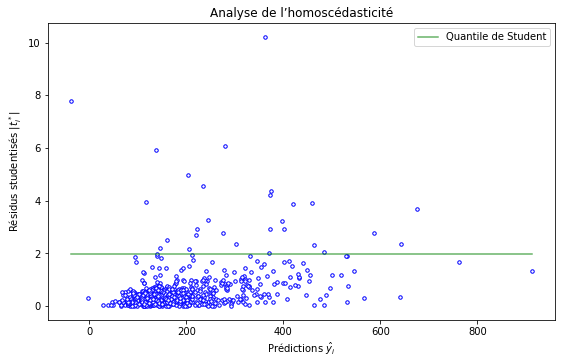

In [19]:
import scipy
Y_pred = regr.predict(X_train)
n = X_train.shape[0]
p = 4
residuals = np.abs(y_train - Y_pred)
H = np.matmul(X_train.values, np.linalg.solve(np.dot(X_train.T.values, X_train.values), X_train.T.values))
std_hat = np.dot(residuals, residuals) / (n - p)
standart_residuals = np.asarray([residuals[i] / np.sqrt(std_hat * (1 - H[i, i])) for i in range(len(residuals))])
student_residuals = np.asarray([ standart_residuals[i] * np.sqrt((n - p - 1) / (n - p - standart_residuals[i]**2)) for i in range(n) ])
cook = np.asarray([ H[i, i] * student_residuals[i] / (X_train.shape[1] * (1 - H[i, i])) for i in range(n) ])

plt.figure(figsize=(20, 12))
plt.subplot(221)
plt.scatter(Y_pred, student_residuals, s=12, c="white", edgecolors="blue")
plt.plot([min(Y_pred), max(Y_pred)], [ scipy.stats.t.ppf(q=0.975, df=n-p-1), scipy.stats.t.ppf(q=0.975, df=n-p-1)], color="green", alpha=0.6, label="Quantile de Student")
plt.title("Analyse de l’homoscédasticité")
plt.xlabel("Prédictions $\hat{y}_i$")
plt.ylabel("Résidus studentisés $|t_i^*|$")
plt.legend()